## Importing and reading data from svc

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
white_path = "wine-white.csv"
red_path = "wine-red.csv"

def import_merge_df(file_name1, file_name2):
    #white wines
    df1 = pd.read_csv(file_name1)
    df1['type']='white'
    #red wines
    df2 = pd.read_csv(file_name2)
    df2['type']='red'
    print(df1.shape)
    print(df2.shape)
    # merge the dataframes 
    df = pd.concat([df1, df2], ignore_index=True)
    return df


df = import_merge_df(red_path, white_path)
df

(1599, 13)
(4898, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,white
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,white
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,white
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,white
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,red
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,red
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,red
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,red


## Splitting data into features and labels

The 'type' of the wine is the label in this question, and the rest are the features.

In [4]:
features = df.drop('type',1)
labels = df['type']

print(features.shape, labels.shape) 

(6497, 12) (6497,)


## Finding ideal number of components and applying PCA

,explained variance
0,0.000000
1,0.740005
2,0.943718
3,0.970472
4,0.984737
5,0.995583
6,0.998867
7,0.999671
8,0.999832
9,0.999934


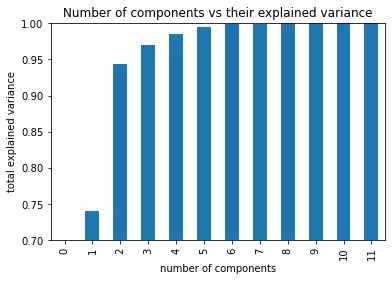

In [8]:
from sklearn.model_selection import train_test_split

#scale data first
features_norm = normalize(features)
#fixed seed for comparing different n_component numbers
seed = 5026
x_train, x_test, y_train, y_test = train_test_split(features_norm, labels, test_size=0.25, random_state=seed)

variance={'explained variance':[]}

for k in range(0,12):
    pca = PCA(n_components=k).fit(x_train)
    variance['explained variance'].append(pca.explained_variance_ratio_.sum())

df = pd.DataFrame(variance)

ax = df.plot.bar(ylim=(0.70,1.001),title="Number of components vs their explained variance")
ax.set_xlabel("number of components")
ax.set_ylabel("total explained variance")
ax.get_legend().remove()

df

The graph above shows different components and their explained variances. There is no way to get 100% explained variation, however it is possible to get close. In `Jake VanderPlas`'s `Python Data Science Handbook` he states that having anywhere over 90% of the total variance explained is good enough to model the dataset. In our case all of the explained variances for components higher than or equal to 2 have sufficient explained variance. Since we are trying to reduce the number of componenets as far as possible, we chose 2 as the number of components to use.

## Finding best KNN (WIth PCA)

Before we compare different models we need to narrow down which number of neighbours for `KNN` yields the highest train and test score. We will look at the weighted train test accuracies for all odd `k`'s in the range of `k` = 1 to `k` = 25.



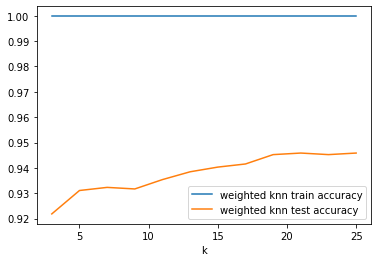

In [9]:
from sklearn.neighbors import KNeighborsClassifier

#Fixed seed for all different Ks
seed = 5026
x_train, x_test, y_train, y_test = train_test_split(features_norm, labels, test_size=0.25, random_state=seed)

#number of components from above
comp_num = 2

pca = PCA(n_components=comp_num)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

def test_knn(k_range, X_train, X_test, y_train, y_test, **knn_params):
#     knn_tmp = pd.DataFrame()
    knn_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,**knn_params)
        knn.fit(X_train, y_train)
        knn_score_train = knn.score(X_train, y_train)
        knn_score_test = knn.score(X_test, y_test)
        
        values = (k,knn_score_train,knn_score_test)
        knn_list.append(values)
    
    
    knn_tmp = pd.DataFrame(knn_list, columns =['k', 'train_score', 'test_score']).set_index('k')
    return knn_tmp


weights={'weights':'distance'}
knn_score_weighted = test_knn(range(3,26,2), x_train, x_test, y_train, y_test, **weights)

ax = knn_score_weighted.plot()
ax.legend(["weighted knn train accuracy", "weighted knn test accuracy","lr score"]);

In [10]:
bestK = knn_score_weighted['test_score'].idxmax()
print(bestK)

21


As we can see from above the `k` with the highest test accuracy is `k` = 21. We can now compare different models to find the model best fitted for predicted the type of wine. Previously, when PCA was not used, k was 11 

## Finding the best classifiers 

To accurately compare the performance of different models the models need to be trained and tested on the same data sets, we will achieve this by using a fixed random seed. We will loop over 30 seeds to get an average score for each of the models. 

The different models we are testing are 
- Logistic Regression (using `liblinear` solver)
- K neighbours (using `KNeighborsClassifier`)
- Linear SVM (using `svm.SVC` with `kernel=linear`)

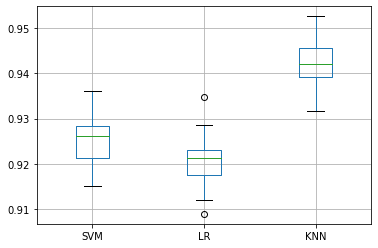

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

scores = {name: [] for name in ('SVM', 'LR', 'KNN')}

for seed in range(5000,5031):
    x_train, x_test, y_train, y_test = train_test_split(features_norm, labels, test_size=0.25, random_state=seed)
    
    pca = PCA(n_components=comp_num)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
   
    lsvc = svm.SVC(kernel='linear').fit(x_train, y_train)
    logisticRegr = LogisticRegression(max_iter=1000,solver = 'liblinear').fit(x_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=bestK,**weights).fit(x_train, y_train)

    
    scores['SVM'].append(lsvc.score(x_test,y_test))
    scores['LR'].append(logisticRegr.score(x_test,y_test))
    scores['KNN'].append(knn.score(x_test,y_test))
    

df = pd.DataFrame(scores)
df.boxplot()

From the results above the `knn` model seems to yeild the highest test prediction accuracy. However, this may not be the best approach, another way to increase the accuracy is to train multiple models and use an ensemble of them for predictions. 

## Combined Ensemble Model

In this section we will train  `linear svm`, `logistic regression` and `kneighbours` models and create a combined model of the three. The combined model will use a voting classifier to decide between the three models.

In [13]:
from sklearn.ensemble import VotingClassifier

#create and return trained models
def create_models(x_train, y_train):
    models = []
    
    weights={'weights':'distance'}
    lsvc = svm.SVC(kernel='linear').fit(x_train, y_train)
    logisticRegr = LogisticRegression(max_iter=1000,solver = 'liblinear').fit(x_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=bestK,**weights).fit(x_train, y_train)
    
    models.append(lsvc)
    models.append(logisticRegr)
    models.append(knn)
    
    return models

models = create_models(x_train, y_train)

In [14]:
from scipy.stats import mode

#function used to predict for combined model
def predict(models, X):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
        result = mode(predictions)[0][0]
    return result

5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030


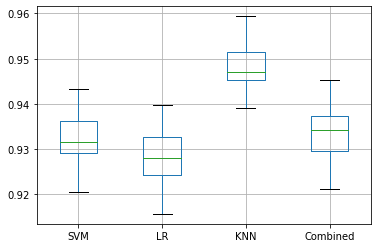

In [9]:
from sklearn.metrics import accuracy_score

scores = {name: [] for name in ('SVM', 'LR', 'KNN', 'Combined')}

for seed in range(5000,5031):
    print(seed)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=seed)
    
    pca = PCA(n_components=comp_num)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
    model_list = create_models(x_train, y_train)
    combined_model = predict(model_list, x_test)
    
    scores['SVM'].append(model_list[0].score(x_test,y_test))
    scores['LR'].append(model_list[1].score(x_test,y_test))
    scores['KNN'].append(model_list[2].score(x_test,y_test))
    scores['Combined'].append(accuracy_score(y_test,combined_model))

df = pd.DataFrame(scores)
df.boxplot()

We can see from above that the `KNN` model remains as the model with the highest test scores, therefor this model is best suited to predict the wine type (red or white) based off of the features in our data set.

It is important to note that without the dimension reduction the `svm.SVC` model performed the best.